# Deep dive into CNN architecture and Build a simple Semantic segmentation model

**Author**: Thien Tran

**Last update**: 21 Oct 2021

## CNN Architecture

Extract from `torchvision`'s ResNet. Source: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

```python
class ResNet(nn.Module):
    # other methods ...

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)            # start of stage 1
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)          # start of stage 2?

        x = self.layer1(x)
        x = self.layer2(x)           # stage 3
        x = self.layer3(x)           # stage 4
        x = self.layer4(x)           # stage 5

        x = self.avgpool(x)          # output head for classification task
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
```

**Stage 1** Standard conv-bn-relu block. Only 1 conv layer. Note that this conv layer uses 5x5 kernel.

```python
x = self.conv1(x)
x = self.bn1(x)
x = self.relu(x)
```

**Stage 2** Downsampling is performed by the max pooling layer. `self.layer1` consists of many conv-bn-relu blocks stacked on top of each other

```python
x = self.maxpool(x)
x = self.layer1(x)
```

**Stage 3, 4, and 5** Downsampling is performed by the first convolution layer, by using stride=2

```python
x = self.layer2(x)
x = self.layer3(x)
x = self.layer4(x)
```

**Decoder** interprets the encoded information provided by the encoder. Image classification decoder

```python
x = self.avgpool(x)
x = torch.flatten(x, 1)
x = self.fc(x)
```

In [1]:
from torchvision.models import resnet34

model = resnet34(pretrained=True)       # load a pretrained model
model = model.eval()                    # put in evaluation mode. important for batch norm

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [2]:
from torch import nn

stage1 = nn.Sequential(model.conv1, model.bn1, model.relu)
stage2 = nn.Sequential(model.maxpool, model.layer1)
stage3 = model.layer2
stage4 = model.layer3
stage5 = model.layer4

## Examine the feature map dimensions

In [3]:
import torch

sample_input = torch.rand((1,3,512,512))
print("Input:", sample_input.shape)

Input: torch.Size([1, 3, 512, 512])


In [4]:
out = stage1(sample_input)
print("Stage 1:", out.shape)

Stage 1: torch.Size([1, 64, 256, 256])


In [5]:
out = stage2(out)
print("Stage 2:", out.shape)

Stage 2: torch.Size([1, 64, 128, 128])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:
out = stage3(out)
print("Stage 3:", out.shape)

Stage 3: torch.Size([1, 128, 64, 64])


In [7]:
out = stage4(out)
print("Stage 4:", out.shape)

Stage 4: torch.Size([1, 256, 32, 32])


In [8]:
out = stage5(out)
print("Stage 5:", out.shape)

Stage 5: torch.Size([1, 512, 16, 16])


## Examine feature maps after each stage

Source: https://www.flickr.com/photos/skymatthews/49852239266

In [9]:
!wget https://live.staticflickr.com/65535/49852239266_6d2486b7e3_k_d.jpg -O sample.jpg

--2021-10-21 12:56:47--  https://live.staticflickr.com/65535/49852239266_6d2486b7e3_k_d.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 52.85.72.96, 2600:9000:2029:8000:0:5a51:64c9:c681, 2600:9000:2029:4a00:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|52.85.72.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg              [ <=>                ] 359.05K  --.-KB/s    in 0.04s   

2021-10-21 12:56:47 (9.80 MB/s) - ‘sample.jpg’ saved [367671]



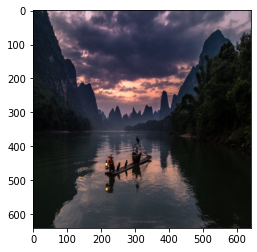

In [18]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("sample.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (640,640))

plt.imshow(img)

Convolution is not scale-invariant

In [19]:
# pre-processing
img = img.transpose(2,0,1)                  # convert HWC to CHW
img = torch.from_numpy(img).unsqueeze(0)    # add batch dimension → NCHW
img = img.float() / 255                     # convert to float 32 and normalize to [0,1]
print(img.shape)

torch.Size([1, 3, 640, 640])


In [20]:
def visualize(feature_maps):
    # 4x4
    plt.figure(figsize=(20,12))
    max_map, _ = torch.max(feature_maps, dim=1)     # max pooling
    plt.subplot(4,4,1)
    plt.imshow(max_map.squeeze().numpy())
    
    for i in range(15):                             # first 15 feature maps
        plt.subplot(4,4,i+2)
        plt.imshow(feature_maps[0,i].numpy())

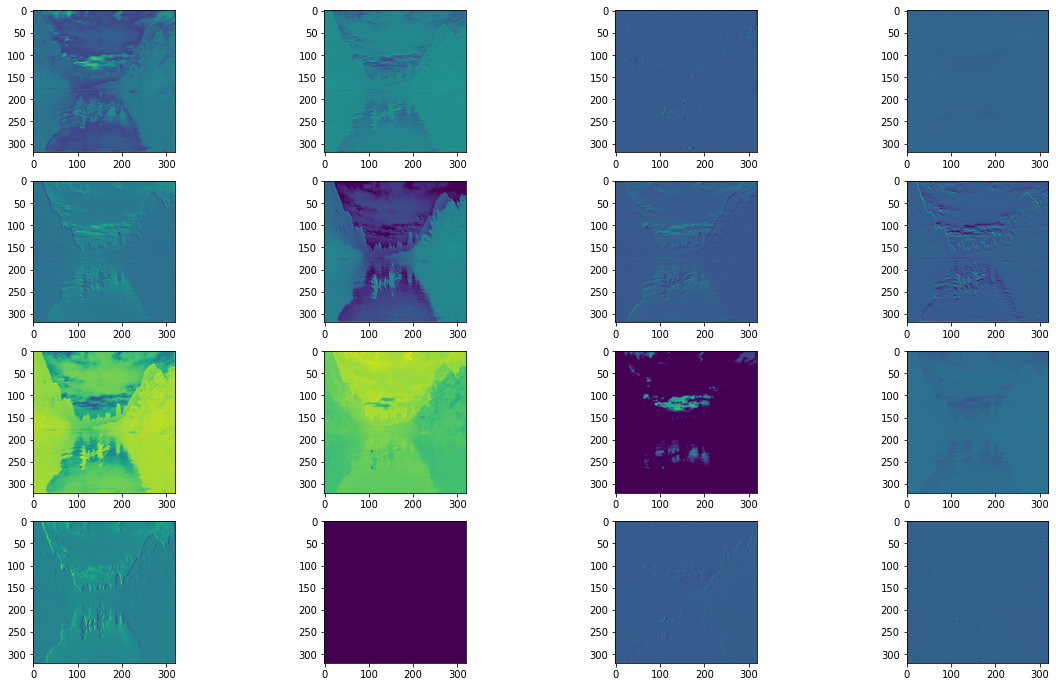

In [21]:
with torch.no_grad():               # tell pytorch to not record the gradients
    out1 = stage1(img)

visualize(out1)

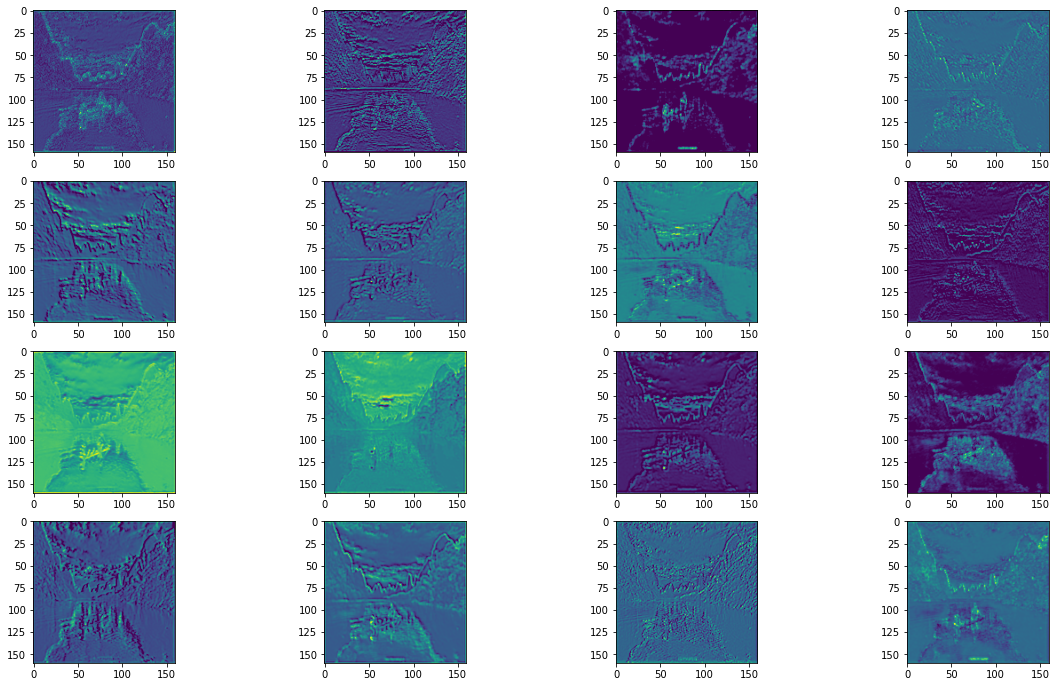

In [22]:
with torch.no_grad():
    out2 = stage2(out1)

visualize(out2)

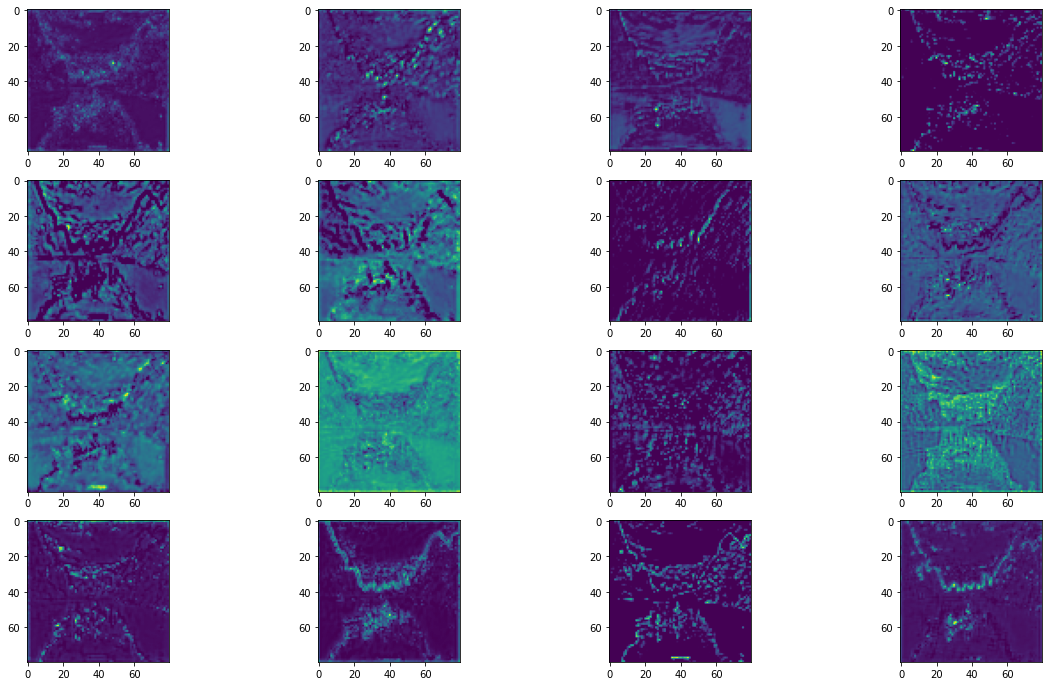

In [23]:
with torch.no_grad():
    out3 = stage3(out2)

visualize(out3)

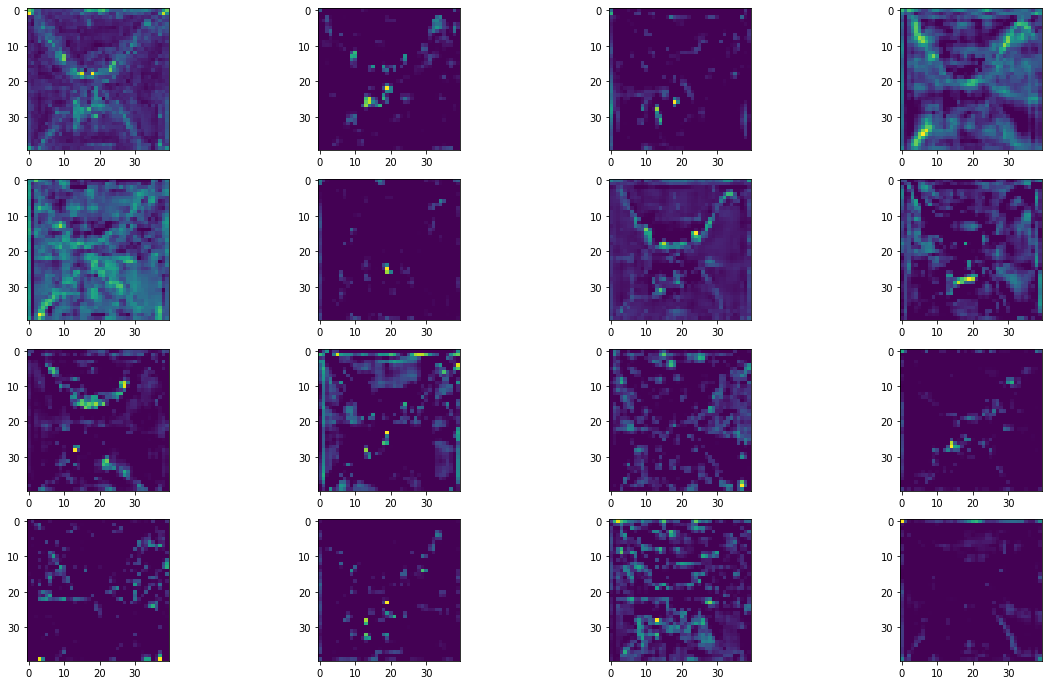

In [24]:
with torch.no_grad():
    out4 = stage4(out3)

visualize(out4)

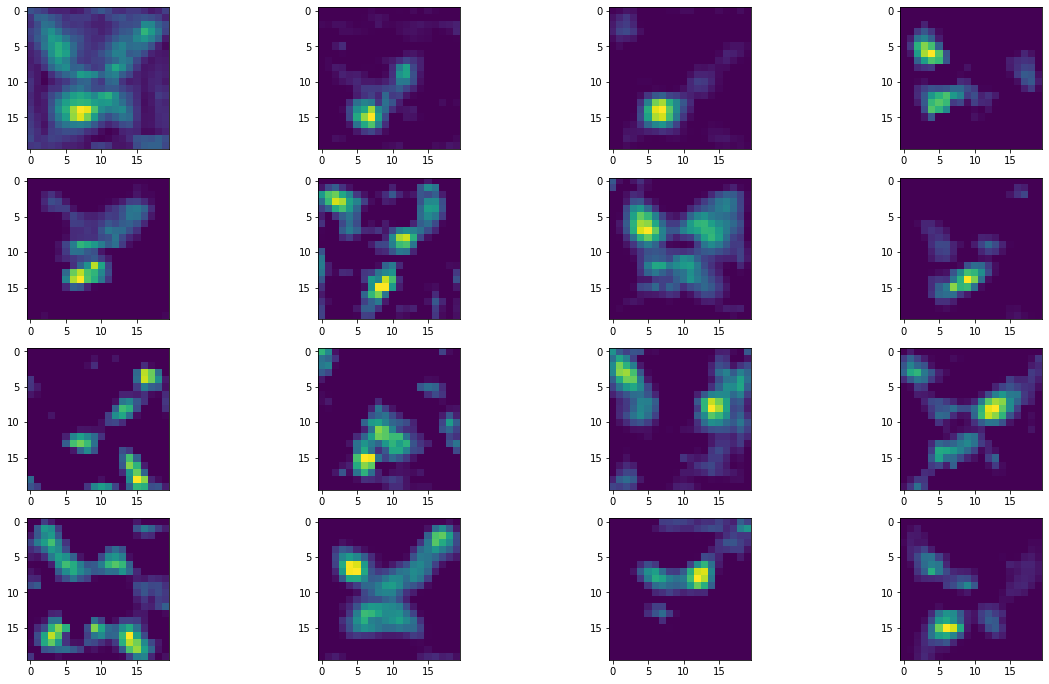

In [25]:
with torch.no_grad():
    out5 = stage5(out4)

visualize(out5)

## Semantic segmentation

Reading about Semantic segmentation: https://nanonets.com/blog/semantic-image-segmentation-2020/

Dataset: https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery

Class | Color
------|------
Building | #3C1098
Land (unpaved area) | #8429F6
Road | #6EC1E4
Vegetation | #FEDD3A
Water | #E2A929
Unlabeled | #9B9B9B

In [26]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery
!unzip -q semantic-segmentation-of-aerial-imagery.zip

 91% 27.0M/29.6M [00:00<00:00, 33.2MB/s]
100% 29.6M/29.6M [00:00<00:00, 33.9MB/s]


Prepare dataset

Found 72 images


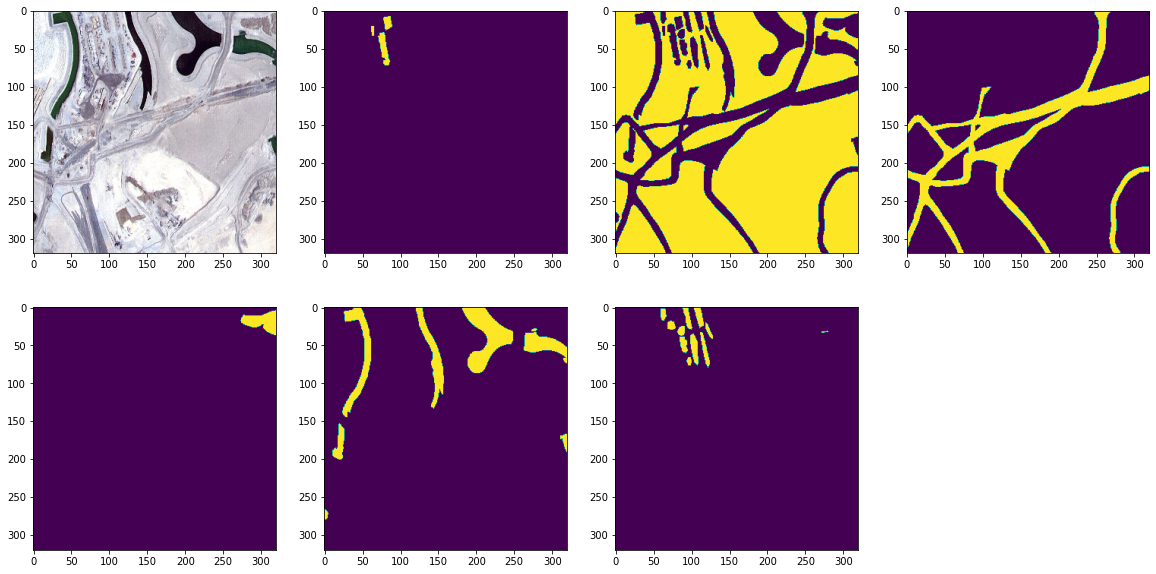

In [28]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

class AerialDataset(Dataset):
    _colors = [
        np.array([60, 16, 152]),
        np.array([132, 41, 246]),
        np.array([110, 193, 228]),
        np.array([254, 221, 58]),
        np.array([226, 169, 41]),
        np.array([155, 155, 155])
    ]

    def __init__(self, data_dir, resize=None, return_tensor=True):
        super().__init__()
        if resize is None:
            resize = (320, 320)
        self.resize = resize
        self.return_tensor = return_tensor

        folders = [x for x in os.listdir(data_dir) if "." not in x]
        folders.sort()

        self.images = []
        self.masks = []
        for folder in folders:
            names = os.listdir(os.path.join(data_dir, folder, "images"))
            names = [os.path.splitext(x)[0] for x in names]
            names.sort()
           
            images = [os.path.join(data_dir, folder, "images", f"{x}.jpg") for x in names]
            masks = [os.path.join(data_dir, folder, "masks", f"{x}.png") for x in names]
            self.images.extend(images)
            self.masks.extend(masks)

        print(f"Found {len(self.images)} images")

    def __getitem__(self, idx):
        # read image
        img = cv2.imread(self.images[idx])
        img = cv2.resize(img, self.resize)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255
        
        # read the mask
        mask = cv2.imread(self.masks[idx])
        mask = cv2.resize(mask, self.resize, interpolation=cv2.INTER_NEAREST)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = [(mask == x).astype(np.float32).mean(axis=-1) for x in self._colors]     # map the color to the class
        mask = np.stack(mask, axis=-1)

        if self.return_tensor:
            img = torch.from_numpy(img.transpose(2,0,1))
            mask = torch.from_numpy(mask.transpose(2,0,1))
            mask = torch.argmax(mask, dim=0)

        return img, mask

    def __len__(self):
        return len(self.images)

dataset = AerialDataset("Semantic segmentation dataset", return_tensor=False)
img, mask = dataset[0]

plt.figure(figsize=(20,10))
plt.subplot(2,4,1)
plt.imshow(img)
for i in range(mask.shape[-1]):
    plt.subplot(2,4,i+2)
    plt.imshow(mask[...,i])

Can't classify based on 1 pixel alone

**Context** 

In [30]:
!pip install pytorch-lightning -q

In [39]:
from torch import nn
import torch.nn.functional as F
from torchvision.models import resnet34
import pytorch_lightning as pl

class SegmentationModel(pl.LightningModule):
    def __init__(self, upsample_channels=None, out_channels=6, lr=1e-3):
        super().__init__()
        backbone = resnet34(pretrained=True)
        self.stage1 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu)
        self.stage2 = nn.Sequential(backbone.maxpool, backbone.layer1)
        self.stage3 = backbone.layer2
        self.stage4 = backbone.layer3
        self.stage5 = backbone.layer4

        if upsample_channels is None:
            upsample_channels = [256, 128, 64]
        assert len(upsample_channels) == 3

        self.up1 = self.make_upsample(512, upsample_channels[0])
        self.up2 = self.make_upsample(upsample_channels[0], upsample_channels[1])
        self.up3 = self.make_upsample(upsample_channels[1], upsample_channels[2])
        
        self.out_conv = nn.Conv2d(upsample_channels[-1], out_channels, kernel_size=3, padding=1)

        # 256, 128, and 64 are output channels for stage 4, stage 3, and stage 2 of ResNet-34
        self.lateral1 = nn.Conv2d(256, upsample_channels[0], kernel_size=1)
        self.lateral2 = nn.Conv2d(128, upsample_channels[1], kernel_size=1)
        self.lateral3 = nn.Conv2d(64, upsample_channels[2], kernel_size=1)

        self.lr = lr

    def make_upsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Upsample(scale_factor=2),            # convolution transpose (GAN)
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):                   # 320 x 320
        # encoder from the image classification CNN model
        down1 = self.stage1(x)              # 160 x 160
        down2 = self.stage2(down1)          # 80 x 80
        down3 = self.stage3(down2)          # 40 x 40
        down4 = self.stage4(down3)          # 20 x 20
        down5 = self.stage5(down4)          # 10 x 10

        # decoder: upsample image after each layer/stage
        # Feature Pyramid Network (FPN)
        # U-Net: concatenation
        up1 = self.up1(down5)                               # 20 x 20 
        up2 = self.up2(up1 + self.lateral1(down4))          # 40 x 40
        up3 = self.up3(up2 + self.lateral2(down3))          # 80 x 80
        out = self.out_conv(up3 + self.lateral3(down2))     # match the number of channels/classes

        return out          # 80 x 80 (1/4 dimension of the input)

    def training_step(self, batch, batch_idx):      # calculate the loss
        img, mask = batch
        out = self(img)             # pass the image thru the network. 80 x 80
        if out.shape[-2:] != mask.shape[-2:]:
            out = F.interpolate(out, size=mask.shape[-2:])      # resize the output to match the size of the mask
        
        loss = F.cross_entropy(out, mask)       # classification
        self.log("train/loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        out = self(img)
        if out.shape[-2:] != mask.shape[-2:]:
            out = F.interpolate(out, size=mask.shape[-2:])
        
        loss = F.cross_entropy(out, mask)
        self.log("val/loss", loss)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), self.lr, weight_decay=1e-5)
        return optimizer

model = SegmentationModel()
model(torch.rand((1,3,512,512))).shape

torch.Size([1, 6, 128, 128])

In [40]:
trainer = pl.Trainer(
    gpus=1,
    precision=16,
    max_epochs=20,
)

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [41]:
from torch.utils.data import random_split

dataset = AerialDataset("Semantic segmentation dataset")
ds_size = len(dataset)
test_size = ds_size // 5
train_size = ds_size - test_size

train_ds, test_ds = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_ds, batch_size=128, shuffle=False, pin_memory=True)

Found 72 images


In [42]:
trainer.fit(model, train_dataloader, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type       | Params
-----------------------------------------
0  | stage1   | Sequential | 9.5 K 
1  | stage2   | Sequential | 221 K 
2  | stage3   | Sequential | 1.1 M 
3  | stage4   | Sequential | 6.8 M 
4  | stage5   | Sequential | 13.1 M
5  | up1      | Sequential | 1.2 M 
6  | up2      | Sequential | 295 K 
7  | up3      | Sequential | 73.9 K
8  | out_conv | Conv2d     | 3.5 K 
9  | lateral1 | Conv2d     | 65.8 K
10 | lateral2 | Conv2d     | 16.5 K
11 | lateral3 | Conv2d     | 4.2 K 
-----------------------------------------
22.9 M    Trainable params
0         Non-trainable params
22.9 M    Total params
91.695    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:327: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

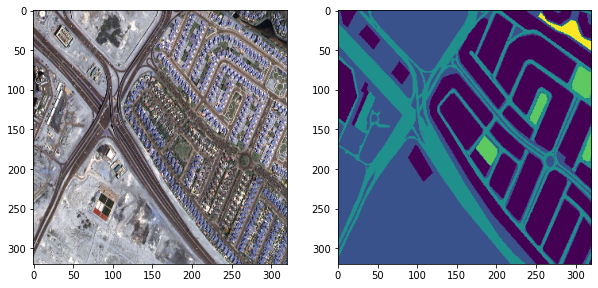

In [43]:
img, mask = test_ds[0]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img.numpy().transpose(1,2,0))
plt.subplot(1,2,2)
plt.imshow(mask.numpy())

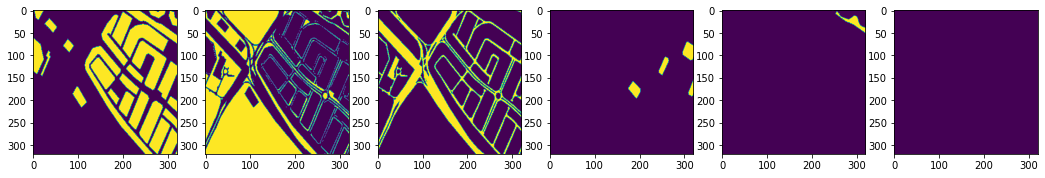

In [44]:
plt.figure(figsize=(18,3))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(mask.numpy() == i)

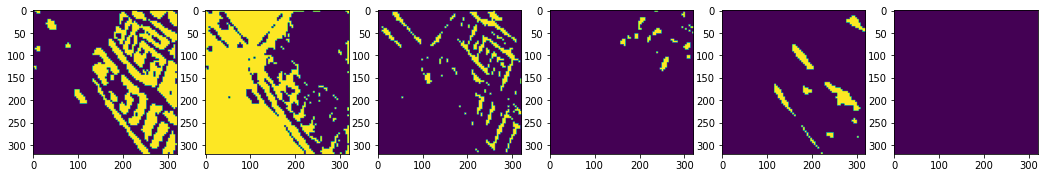

In [45]:
model.eval()
with torch.no_grad():
    out = model(img.unsqueeze(0))

out = F.interpolate(out, size=(320,320)).squeeze().numpy().transpose(1,2,0)
out = np.argmax(out, axis=-1)

plt.figure(figsize=(18,3))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(out == i)